# Catechol Benchmark Hackathon (NeurIPS 2025 DnB)

## Competition Overview
- **Goal**: Predict reaction outcomes of allyl substituted catechol rearrangement
- **Dataset**: 1227 data points covering 24 solvents at different temperatures and residence times
- **Inputs**: 
  - Solvent A and Solvent B with %B mixture percentage
  - Temperature (°C)
  - Residence time
- **Outputs**: Yield of starting material and two observed products
- **Evaluation**: Cross-validation procedure on unseen solvent data

In [33]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Load and Explore Data

In [34]:
# Set data path
data_path = r"C:\Users\gopeami\OneDrive - Vesuvius\Desktop\PhD13- 2025-2026\ML Practice\Kaggle Compettition\Catechol Benchmark Hackathon\catechol-benchmark-hackathon"

# List files in the directory
import os
if os.path.exists(data_path):
    files = os.listdir(data_path)
    print(f"Files in directory:\n{files}")
else:
    print(f"Path does not exist: {data_path}")

Files in directory:
['acs_pca_descriptors_lookup.csv', 'catechol_full_data_yields.csv', 'catechol_single_solvent_yields.csv', 'drfps_catechol_lookup.csv', 'fragprints_lookup.csv', 'smiles_lookup.csv', 'spange_descriptors_lookup.csv', 'utils.py', '__pycache__']


In [35]:
# Load the main datasets
df_full = pd.read_csv(os.path.join(data_path, 'catechol_full_data_yields.csv'))
df_single = pd.read_csv(os.path.join(data_path, 'catechol_single_solvent_yields.csv'))

print("Full Dataset Shape:", df_full.shape)
print("\nFull Dataset Columns:")
print(df_full.columns.tolist())
print("\n" + "="*80)
print("\nSingle Solvent Dataset Shape:", df_single.shape)
print("\nSingle Solvent Dataset Columns:")
print(df_single.columns.tolist())

Full Dataset Shape: (1227, 19)

Full Dataset Columns:
['EXP NUM', 'SOLVENT A NAME', 'SOLVENT B NAME', 'SolventB%', 'Residence Time', 'Temperature', 'SM', 'Product 2', 'Product 3', 'SM SMILES', 'Product 2 SMILES', 'Product 3 SMILES', 'SOLVENT A SMILES', 'SOLVENT B SMILES', 'SOLVENT A Ratio', 'SOLVENT B Ratio', 'Reaction SMILES A', 'Reaction SMILES B', 'RAMP NUM']


Single Solvent Dataset Shape: (656, 13)

Single Solvent Dataset Columns:
['EXP NUM', 'Residence Time', 'Temperature', 'SM', 'Product 2', 'Product 3', 'SM SMILES', 'Product 2 SMILES', 'Product 3 SMILES', 'SOLVENT NAME', 'SOLVENT SMILES', 'SOLVENT Ratio', 'Reaction SMILES']


In [36]:
# Display first few rows of full dataset
print("Full Dataset Sample:")
print(df_full.head())
print("\n" + "="*80)
print("\nFull Dataset Info:")
print(df_full.info())
print("\n" + "="*80)
print("\nBasic Statistics:")
print(df_full.describe())

Full Dataset Sample:
   EXP NUM SOLVENT A NAME                    SOLVENT B NAME  SolventB%  \
0        0       Methanol  Ethylene Glycol [1,2-Ethanediol]        0.0   
1        0       Methanol  Ethylene Glycol [1,2-Ethanediol]        0.0   
2        0       Methanol  Ethylene Glycol [1,2-Ethanediol]        0.0   
3        0       Methanol  Ethylene Glycol [1,2-Ethanediol]        0.0   
4        0       Methanol  Ethylene Glycol [1,2-Ethanediol]        0.0   

   Residence Time  Temperature        SM  Product 2  Product 3  \
0        2.001019        175.0  0.903118   0.000000   0.000000   
1        3.978167        175.0  0.898313   0.000000   0.000000   
2        7.011797        175.0  0.897077   0.006710   0.005429   
3       10.031130        175.0  0.876802   0.014084   0.010995   
4       13.079227        175.0  0.857585   0.019298   0.013467   

                 SM SMILES           Product 2 SMILES  \
0  C=CCOC1=C(OCC=C)C=CC=C1  OC1=C(O)C(CC=C)=CC=C1CC=C   
1  C=CCOC1=C(OCC=C)C=CC

In [37]:
# Load solvent descriptor files
smiles_lookup = pd.read_csv(os.path.join(data_path, 'smiles_lookup.csv'))
acs_pca = pd.read_csv(os.path.join(data_path, 'acs_pca_descriptors_lookup.csv'))
spange = pd.read_csv(os.path.join(data_path, 'spange_descriptors_lookup.csv'))

print("SMILES Lookup:", smiles_lookup.shape)
print("ACS PCA Descriptors:", acs_pca.shape)
print("Spange Descriptors:", spange.shape)
print("\nAvailable Solvents:")
print(smiles_lookup)

SMILES Lookup: (26, 2)
ACS PCA Descriptors: (24, 6)
Spange Descriptors: (26, 14)

Available Solvents:
                          SOLVENT NAME              solvent smiles
0                          Cyclohexane                    C1CCCCC1
1                        Ethyl Acetate                   O=C(OCC)C
2                          Acetic Acid                     CC(=O)O
3    2-Methyltetrahydrofuran [2-MeTHF]                  O1C(C)CCC1
4    1,1,1,3,3,3-Hexafluoropropan-2-ol      C(C(F)(F)F)(C(F)(F)F)O
5                    IPA [Propan-2-ol]                      CC(O)C
6                              Ethanol                         CCO
7                             Methanol                          CO
8     Ethylene Glycol [1,2-Ethanediol]                        OCCO
9                         Acetonitrile                        CC#N
10                               Water                           O
11               Diethyl Ether [Ether]                       CCOCC
12        MTBE [tert-Butylm

## 2. Exploratory Data Analysis

In [38]:
# Check target variables (yields)
target_cols = ['SM', 'Product 2', 'Product 3']

# Check for missing values
print("Missing Values in Full Dataset:")
print(df_full[target_cols + ['Temperature', 'Residence Time', 'SolventB%']].isnull().sum())
print("\n" + "="*80)

# Check yield statistics
print("\nYield Statistics:")
print(df_full[target_cols].describe())
print("\n" + "="*80)

# Check if yields sum to approximately 100%
df_full['Total_Yield'] = df_full[target_cols].sum(axis=1)
print("\nTotal Yield Statistics (should be ~100%):")
print(df_full['Total_Yield'].describe())

Missing Values in Full Dataset:
SM                0
Product 2         0
Product 3         0
Temperature       0
Residence Time    0
SolventB%         0
dtype: int64


Yield Statistics:
                SM    Product 2    Product 3
count  1227.000000  1227.000000  1227.000000
mean      0.495178     0.164626     0.143668
std       0.379425     0.153467     0.145779
min       0.000000     0.000000     0.000000
25%       0.068573     0.012723     0.012260
50%       0.606454     0.117330     0.094413
75%       0.877448     0.308649     0.254630
max       1.083254     0.463632     0.533768


Total Yield Statistics (should be ~100%):
count    1227.000000
mean        0.803472
std         0.209172
min         0.011194
25%         0.737871
50%         0.872138
75%         0.942168
max         1.123258
Name: Total_Yield, dtype: float64


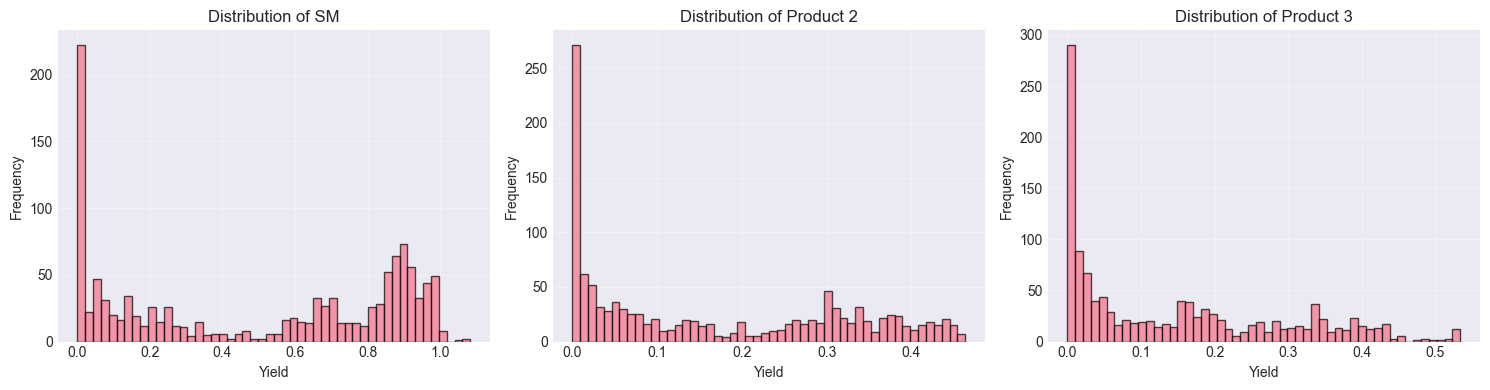


Solvent Distribution:
SOLVENT A NAME
Ethanol                               127
Water.Acetonitrile                    125
Acetonitrile                          125
2,2,2-Trifluoroethanol                125
1,1,1,3,3,3-Hexafluoropropan-2-ol     124
2-Methyltetrahydrofuran [2-MeTHF]     124
Methanol                              122
DMA [N,N-Dimethylacetamide]           110
Cyclohexane                           104
Dihydrolevoglucosenone (Cyrene)        36
tert-Butanol [2-Methylpropan-2-ol]     36
Methyl Propionate                      35
MTBE [tert-Butylmethylether]           34
Name: count, dtype: int64


In [39]:
# Visualize yield distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, col in enumerate(target_cols):
    axes[idx].hist(df_full[col], bins=50, edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'Distribution of {col}')
    axes[idx].set_xlabel('Yield')
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nSolvent Distribution:")
print(df_full['SOLVENT A NAME'].value_counts())

## 3. Feature Engineering

In [40]:
# Merge solvent descriptors with the main dataset
# We'll use the spange descriptors for solvent properties

# Merge for Solvent A
df_merged = df_full.merge(
    spange.add_suffix('_A'),
    left_on='SOLVENT A NAME',
    right_on='SOLVENT NAME_A',
    how='left'
)

# Merge for Solvent B
df_merged = df_merged.merge(
    spange.add_suffix('_B'),
    left_on='SOLVENT B NAME',
    right_on='SOLVENT NAME_B',
    how='left'
)

# Create weighted average of solvent descriptors based on mixture percentage
solvent_desc_cols = [col for col in spange.columns if col != 'SOLVENT NAME']

for col in solvent_desc_cols:
    col_A = f'{col}_A'
    col_B = f'{col}_B'
    
    # Calculate weighted average
    df_merged[f'{col}_weighted'] = (
        df_merged[col_A] * (1 - df_merged['SolventB%']/100) +
        df_merged[col_B] * (df_merged['SolventB%']/100)
    )

print("Merged dataset shape:", df_merged.shape)
print("\nWeighted solvent descriptor columns created:")
weighted_cols = [col for col in df_merged.columns if '_weighted' in col]
print(weighted_cols)

Merged dataset shape: (1227, 61)

Weighted solvent descriptor columns created:
['dielectric constant_weighted', 'ET(30)_weighted', 'alpha_weighted', 'beta_weighted', 'pi*_weighted', 'SA_weighted', 'SB_weighted', 'SP_weighted', 'SdP_weighted', 'N_weighted', 'n_weighted', 'f(n)_weighted', 'delta_weighted']


### 📊 Summary: Advanced Feature Engineering

**What was added:**

1. **ACS PCA Descriptors** (5 features)
   - Principal component analysis-based solvent descriptors
   - Compact representation of solvent properties

2. **Molecular Fingerprints** (2,133 features)
   - Fragment-based molecular fingerprints (Fragprints)
   - Detailed structural information about solvents

3. **DRFP Descriptors** (2,048 features)
   - Deep learning-based reaction fingerprints
   - Captures complex molecular patterns

4. **Polynomial Features** (Temperature × Residence Time interactions)
   - Temperature²
   - Residence Time²
   - Temperature × Residence Time (interaction term)
   - Captures non-linear relationships

5. **Combined Descriptor Option**
   - Uses ALL descriptor types simultaneously
   - Maximum feature richness

**How to use:**

Run the feature comparison cell above to test which combination works best for your model. The `EnhancedFeatureEngineer` class can be used with any model by specifying:
- `descriptor_type`: 'spange', 'acs_pca', 'fragprints', 'drfps', or 'combined'
- `use_polynomial`: True/False

**Expected Impact:**
- Polynomial features typically improve MAE by 0.5-2%
- Different descriptors work better for different models
- Combined descriptors may provide the best results but increase training time

In [51]:
# Compare different feature combinations (testing on 3 folds for speed)
feature_comparison_results = []

feature_configs = [
    ('spange', False, 'Spange only'),
    ('spange', True, 'Spange + Polynomial'),
    ('acs_pca', True, 'ACS PCA + Polynomial'),
    ('fragprints', True, 'Fragprints + Polynomial'),
    ('combined', True, 'All Descriptors + Polynomial'),
]

print("Testing different feature combinations with Gradient Boosting...")
print("="*80)

for desc_type, use_poly, desc_name in feature_configs:
    print(f"\n{desc_name}:")
    print("-"*80)
    
    try:
        _, mae_scores_feat = evaluate_model_with_features(
            model_class=GradientBoostingModel,
            X=X,
            y=y,
            descriptor_dict=descriptor_dict,
            descriptor_type=desc_type,
            use_polynomial=use_poly,
            n_splits=3
        )
        
        feature_comparison_results.append({
            'Feature Set': desc_name,
            'Descriptor Type': desc_type,
            'Polynomial': use_poly,
            'MAE': np.mean(mae_scores_feat),
            'Std': np.std(mae_scores_feat)
        })
    except Exception as e:
        print(f"Error with {desc_name}: {str(e)}")
        continue

print("\n" + "="*80)
print("FEATURE COMPARISON RESULTS:")
print("="*80)
comparison_df = pd.DataFrame(feature_comparison_results)
comparison_df = comparison_df.sort_values('MAE')
print(comparison_df.to_string(index=False))
print("="*80)

Testing different feature combinations with Gradient Boosting...

Spange only:
--------------------------------------------------------------------------------
Running 3 CV folds with:
  - Descriptor type: spange
  - Polynomial features: False
Fold 3/3
Average MAE: 0.1151 ± 0.0085

Spange + Polynomial:
--------------------------------------------------------------------------------
Running 3 CV folds with:
  - Descriptor type: spange
  - Polynomial features: True
Fold 3/3
Average MAE: 0.1134 ± 0.0105

ACS PCA + Polynomial:
--------------------------------------------------------------------------------
Running 3 CV folds with:
  - Descriptor type: acs_pca
  - Polynomial features: True
Fold 3/3
Average MAE: 0.0937 ± 0.0105

Fragprints + Polynomial:
--------------------------------------------------------------------------------
Running 3 CV folds with:
  - Descriptor type: fragprints
  - Polynomial features: True
Fold 3/3
Average MAE: 0.0926 ± 0.0239

All Descriptors + Polynomial:
-----

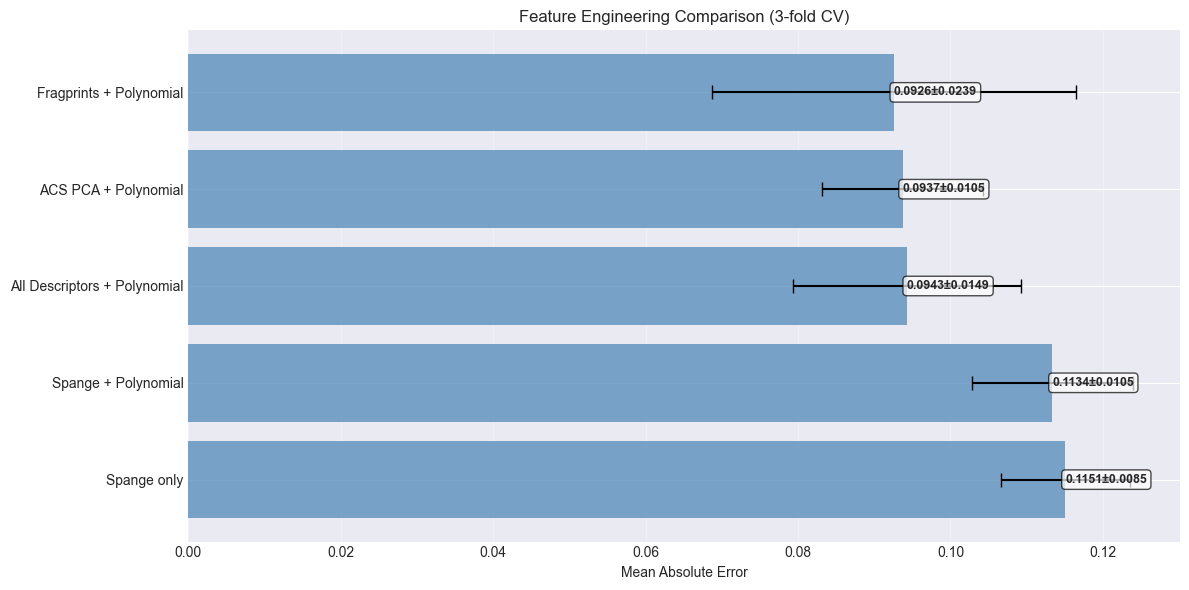


🏆 Best Feature Configuration:
   Feature Set: Fragprints + Polynomial
   MAE: 0.0926 ± 0.0239


In [52]:
# Visualize feature comparison
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

feature_sets = comparison_df['Feature Set']
mae_vals = comparison_df['MAE']
std_vals = comparison_df['Std']

bars = ax.barh(range(len(feature_sets)), mae_vals, xerr=std_vals, 
               capsize=5, alpha=0.7, color='steelblue')
ax.set_yticks(range(len(feature_sets)))
ax.set_yticklabels(feature_sets)
ax.set_xlabel('Mean Absolute Error')
ax.set_title('Feature Engineering Comparison (3-fold CV)')
ax.grid(True, alpha=0.3, axis='x')
ax.invert_yaxis()  # Best at top

# Add value labels
for i, (bar, mae, std) in enumerate(zip(bars, mae_vals, std_vals)):
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2.,
            f'{mae:.4f}±{std:.4f}',
            ha='left', va='center', fontsize=9, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

plt.tight_layout()
plt.show()

# Identify best feature set
best_config = comparison_df.iloc[0]
print(f"\n🏆 Best Feature Configuration:")
print(f"   Feature Set: {best_config['Feature Set']}")
print(f"   MAE: {best_config['MAE']:.4f} ± {best_config['Std']:.4f}")

In [47]:
# Enhanced cross-validation function that supports EnhancedFeatureEngineer
def evaluate_model_with_features(model_class, X, y, descriptor_dict, 
                                  descriptor_type='spange', use_polynomial=True,
                                  n_splits=None):
    """
    Evaluate model with different feature engineering options
    """
    mae_scores = []
    fold_results = []
    
    # Generate splits
    splits = list(generate_leave_one_ramp_out_splits(X, y))
    
    if n_splits is not None:
        splits = splits[:n_splits]
    
    print(f"Running {len(splits)} CV folds with:")
    print(f"  - Descriptor type: {descriptor_type}")
    print(f"  - Polynomial features: {use_polynomial}")
    print("="*80)
    
    for fold_idx, ((X_train, y_train), (X_test, y_test)) in enumerate(splits):
        print(f"Fold {fold_idx + 1}/{len(splits)}", end='\r')
        
        # Feature engineering
        feature_engineer = EnhancedFeatureEngineer(
            descriptor_dfs=descriptor_dict,
            descriptor_type=descriptor_type,
            use_polynomial=use_polynomial,
            poly_degree=2
        )
        X_train_scaled = feature_engineer.fit_transform(X_train)
        X_test_scaled = feature_engineer.transform_scaled(X_test)
        
        # Train model
        model = model_class()
        model.fit(X_train_scaled, y_train.values)
        
        # Predict
        y_pred = model.predict(X_test_scaled)
        
        # Calculate metrics
        mae = mean_absolute_error(y_test, y_pred)
        
        mae_scores.append(mae)
        fold_results.append({
            'fold': fold_idx + 1,
            'mae': mae
        })
    
    print()
    print(f"Average MAE: {np.mean(mae_scores):.4f} ± {np.std(mae_scores):.4f}")
    
    return fold_results, mae_scores

print("Enhanced evaluation function defined!")

Enhanced evaluation function defined!


### 3.4 Test Different Feature Combinations

In [46]:
# Enhanced Feature Engineering Class with multiple descriptor options
class EnhancedFeatureEngineer:
    """
    Advanced feature engineering with multiple descriptor types and polynomial features
    
    Parameters:
    -----------
    descriptor_type : str
        Type of solvent descriptors: 'spange', 'acs_pca', 'fragprints', 'drfps', or 'combined'
    use_polynomial : bool
        Whether to include polynomial features for temperature and residence time
    poly_degree : int
        Degree of polynomial features (default: 2)
    """
    def __init__(self, descriptor_dfs, descriptor_type='spange', 
                 use_polynomial=True, poly_degree=2):
        self.descriptor_dfs = descriptor_dfs  # Dictionary of descriptor DataFrames
        self.descriptor_type = descriptor_type
        self.use_polynomial = use_polynomial
        self.poly_degree = poly_degree
        self.scaler = StandardScaler()
        self.poly = PolynomialFeatures(degree=poly_degree, include_bias=False)
        self.fitted = False
        
    def _get_descriptor_df(self):
        """Select the appropriate descriptor DataFrame"""
        if self.descriptor_type == 'combined':
            # Combine all descriptors
            return None  # Will handle separately
        else:
            return self.descriptor_dfs[self.descriptor_type]
    
    def transform(self, X):
        """Transform input features to numerical features"""
        X_copy = X.copy()
        
        # 1. Extract basic numerical features
        numerical_features = X_copy[['Residence Time', 'Temperature', 'SolventB%']].values
        
        # 2. Create polynomial features if requested
        if self.use_polynomial:
            process_params = X_copy[['Temperature', 'Residence Time']].values
            poly_features = self.poly.fit_transform(process_params)
            # Remove original features (they're already in numerical_features)
            poly_features = poly_features[:, 2:]  # Skip first 2 columns (original temp & res time)
        
        # 3. Get solvent descriptors based on type
        if self.descriptor_type == 'combined':
            # Combine multiple descriptor types
            all_solvent_features = []
            
            for desc_name, desc_df in self.descriptor_dfs.items():
                solvent_a_features = []
                solvent_b_features = []
                
                for idx, row in X_copy.iterrows():
                    solvent_a = row['SOLVENT A NAME']
                    solvent_b = row['SOLVENT B NAME']
                    
                    # Get features for solvent A
                    if solvent_a in desc_df.index:
                        feat_a = desc_df.loc[solvent_a].values
                    else:
                        feat_a = np.zeros(len(desc_df.columns))
                    
                    # Get features for solvent B
                    if solvent_b in desc_df.index:
                        feat_b = desc_df.loc[solvent_b].values
                    else:
                        feat_b = np.zeros(len(desc_df.columns))
                    
                    solvent_a_features.append(feat_a)
                    solvent_b_features.append(feat_b)
                
                solvent_a_features = np.array(solvent_a_features)
                solvent_b_features = np.array(solvent_b_features)
                
                # Calculate weighted average
                solventb_pct = X_copy['SolventB%'].values.reshape(-1, 1) / 100.0
                weighted_features = solvent_a_features * (1 - solventb_pct) + solvent_b_features * solventb_pct
                all_solvent_features.append(weighted_features)
            
            # Concatenate all descriptor types
            solvent_features_combined = np.hstack(all_solvent_features)
            
        else:
            # Use single descriptor type
            desc_df = self._get_descriptor_df()
            solvent_a_features = []
            solvent_b_features = []
            
            for idx, row in X_copy.iterrows():
                solvent_a = row['SOLVENT A NAME']
                solvent_b = row['SOLVENT B NAME']
                
                # Get features for solvent A
                if solvent_a in desc_df.index:
                    feat_a = desc_df.loc[solvent_a].values
                else:
                    feat_a = np.zeros(len(desc_df.columns))
                
                # Get features for solvent B
                if solvent_b in desc_df.index:
                    feat_b = desc_df.loc[solvent_b].values
                else:
                    feat_b = np.zeros(len(desc_df.columns))
                
                solvent_a_features.append(feat_a)
                solvent_b_features.append(feat_b)
            
            solvent_a_features = np.array(solvent_a_features)
            solvent_b_features = np.array(solvent_b_features)
            
            # Calculate weighted average
            solventb_pct = X_copy['SolventB%'].values.reshape(-1, 1) / 100.0
            solvent_features_combined = solvent_a_features * (1 - solventb_pct) + solvent_b_features * solventb_pct
        
        # 4. Combine all features
        if self.use_polynomial:
            all_features = np.hstack([numerical_features, poly_features, solvent_features_combined])
        else:
            all_features = np.hstack([numerical_features, solvent_features_combined])
        
        return all_features
    
    def fit_transform(self, X, y=None):
        X_transformed = self.transform(X)
        X_scaled = self.scaler.fit_transform(X_transformed)
        self.fitted = True
        return X_scaled
    
    def transform_scaled(self, X):
        X_transformed = self.transform(X)
        if self.fitted:
            return self.scaler.transform(X_transformed)
        else:
            raise ValueError("Scaler not fitted yet!")

# Prepare descriptor dictionary
descriptor_dict = {
    'spange': spange.set_index('SOLVENT NAME') if 'SOLVENT NAME' in spange.columns else spange,
    'acs_pca': acs_pca_indexed,
    'fragprints': fragprints_indexed,
    'drfps': drfps_indexed
}

print("Enhanced Feature Engineer defined with options:")
print("- Descriptor types: spange, acs_pca, fragprints, drfps, combined")
print("- Polynomial features: Yes (degree 2)")
print("- Total descriptor features available:")
for name, df in descriptor_dict.items():
    print(f"  {name}: {df.shape[1]} features")

Enhanced Feature Engineer defined with options:
- Descriptor types: spange, acs_pca, fragprints, drfps, combined
- Polynomial features: Yes (degree 2)
- Total descriptor features available:
  spange: 13 features
  acs_pca: 5 features
  fragprints: 2133 features
  drfps: 2048 features


### 3.3 Enhanced Feature Engineer with Multiple Descriptor Options

Polynomial Features Created:
Original features: Temperature, Residence Time
Polynomial features (degree=2): ['Temperature', 'Residence Time', 'Temperature^2', 'Temperature Residence Time', 'Residence Time^2']

Shape: (1227, 5)

Sample:
   Temperature  Residence Time  Temperature^2  Temperature Residence Time  \
0        175.0        2.001019        30625.0                  350.178344   
1        175.0        3.978167        30625.0                  696.179171   
2        175.0        7.011797        30625.0                 1227.064521   
3        175.0       10.031130        30625.0                 1755.447769   
4        175.0       13.079227        30625.0                 2288.864720   

   Residence Time^2  
0          4.004077  
1         15.825810  
2         49.165301  
3        100.623571  
4        171.066178  


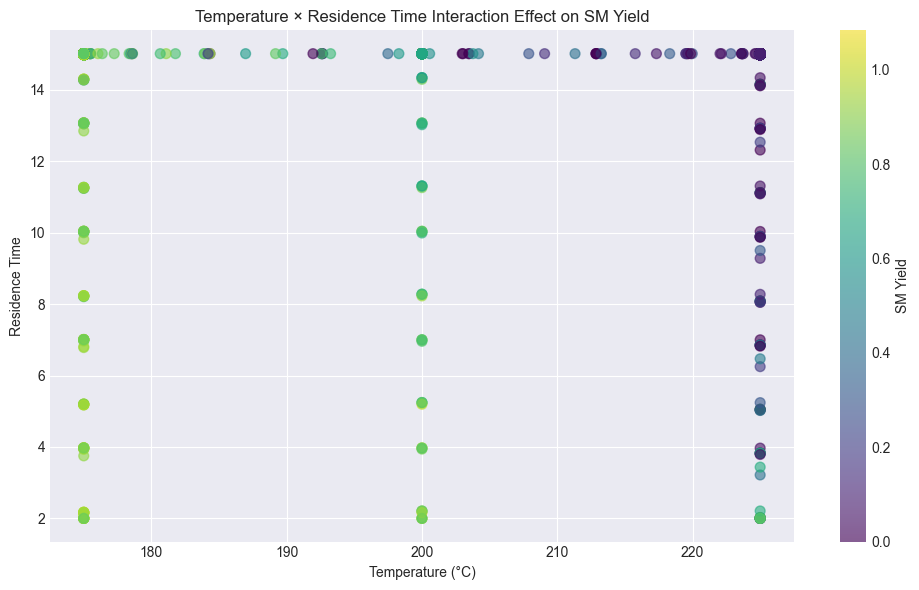

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

# Create polynomial features for Temperature and Residence Time
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)

# Extract temperature and residence time
process_params = df_full[['Temperature', 'Residence Time']].values

# Generate polynomial features
poly_features = poly.fit_transform(process_params)
poly_feature_names = poly.get_feature_names_out(['Temperature', 'Residence Time'])

# Create DataFrame with polynomial features
poly_df = pd.DataFrame(poly_features, columns=poly_feature_names, index=df_full.index)

print("Polynomial Features Created:")
print(f"Original features: Temperature, Residence Time")
print(f"Polynomial features (degree=2): {poly_feature_names.tolist()}")
print(f"\nShape: {poly_df.shape}")
print("\nSample:")
print(poly_df.head())

# Visualize interaction effect in 3D
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14, 10))

# 3D scatter plot
ax1 = fig.add_subplot(221, projection='3d')
scatter = ax1.scatter(
    df_full['Temperature'], 
    df_full['Residence Time'],
    df_full['SM'],
    c=df_full['SM'],
    cmap='viridis',
    alpha=0.6,
    s=50,
    edgecolors='k',
    linewidths=0.5
)
ax1.set_xlabel('Temperature (°C)', fontsize=10)
ax1.set_ylabel('Residence Time', fontsize=10)
ax1.set_zlabel('SM Yield', fontsize=10)
ax1.set_title('3D: Temperature × Residence Time → SM Yield', fontsize=11, fontweight='bold')
fig.colorbar(scatter, ax=ax1, label='SM Yield', shrink=0.5, aspect=5)

# 3D scatter plot for Product 2
ax2 = fig.add_subplot(222, projection='3d')
scatter2 = ax2.scatter(
    df_full['Temperature'], 
    df_full['Residence Time'],
    df_full['Product 2'],
    c=df_full['Product 2'],
    cmap='plasma',
    alpha=0.6,
    s=50,
    edgecolors='k',
    linewidths=0.5
)
ax2.set_xlabel('Temperature (°C)', fontsize=10)
ax2.set_ylabel('Residence Time', fontsize=10)
ax2.set_zlabel('Product 2 Yield', fontsize=10)
ax2.set_title('3D: Temperature × Residence Time → Product 2 Yield', fontsize=11, fontweight='bold')
fig.colorbar(scatter2, ax=ax2, label='Product 2 Yield', shrink=0.5, aspect=5)

# 3D scatter plot for Product 3
ax3 = fig.add_subplot(223, projection='3d')
scatter3 = ax3.scatter(
    df_full['Temperature'], 
    df_full['Residence Time'],
    df_full['Product 3'],
    c=df_full['Product 3'],
    cmap='coolwarm',
    alpha=0.6,
    s=50,
    edgecolors='k',
    linewidths=0.5
)
ax3.set_xlabel('Temperature (°C)', fontsize=10)
ax3.set_ylabel('Residence Time', fontsize=10)
ax3.set_zlabel('Product 3 Yield', fontsize=10)
ax3.set_title('3D: Temperature × Residence Time → Product 3 Yield', fontsize=11, fontweight='bold')
fig.colorbar(scatter3, ax=ax3, label='Product 3 Yield', shrink=0.5, aspect=5)

# 2D contour plot for reference
ax4 = fig.add_subplot(224)
scatter4 = ax4.scatter(
    df_full['Temperature'], 
    df_full['Residence Time'],
    c=df_full['SM'],
    cmap='viridis',
    alpha=0.6,
    s=50,
    edgecolors='k',
    linewidths=0.5
)
ax4.set_xlabel('Temperature (°C)', fontsize=10)
ax4.set_ylabel('Residence Time', fontsize=10)
ax4.set_title('2D: Temperature × Residence Time (SM Yield)', fontsize=11, fontweight='bold')
ax4.grid(True, alpha=0.3)
fig.colorbar(scatter4, ax=ax4, label='SM Yield', shrink=0.8)

plt.tight_layout()
plt.show()

### 3.2 Create Polynomial Features for Process Parameters

In [44]:
# Load DRFP descriptors (another fingerprint type)
drfps = pd.read_csv(os.path.join(data_path, 'drfps_catechol_lookup.csv'))
drfps_indexed = drfps.copy()
drfps_indexed.set_index('SOLVENT NAME', inplace=True)

print("DRFP Descriptors:")
print(f"Shape: {drfps_indexed.shape}")
print(f"Number of DRFP features: {len(drfps_indexed.columns)}")
print("\nSample:")
print(drfps_indexed.iloc[:3, :10])  # Show first 3 rows, 10 columns

DRFP Descriptors:
Shape: (24, 2048)
Number of DRFP features: 2048

Sample:
                                     0    1    2    3    4    5    6    7  \
SOLVENT NAME                                                                
Methanol                           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Ethylene Glycol [1,2-Ethanediol]   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1,1,1,3,3,3-Hexafluoropropan-2-ol  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

                                     8    9  
SOLVENT NAME                                 
Methanol                           0.0  0.0  
Ethylene Glycol [1,2-Ethanediol]   0.0  0.0  
1,1,1,3,3,3-Hexafluoropropan-2-ol  0.0  0.0  


In [43]:
# Load molecular fingerprints
fragprints = pd.read_csv(os.path.join(data_path, 'fragprints_lookup.csv'))
fragprints_indexed = fragprints.copy()
fragprints_indexed.set_index('SOLVENT NAME', inplace=True)

print("Molecular Fingerprints (Fragprints):")
print(f"Shape: {fragprints_indexed.shape}")
print(f"Number of fingerprint features: {len(fragprints_indexed.columns)}")
print("\nSample:")
print(fragprints_indexed.iloc[:3, :10])  # Show first 3 rows, 10 columns

Molecular Fingerprints (Fragprints):
Shape: (24, 2133)
Number of fingerprint features: 2133

Sample:
                                   0  1  2  3  4  5  6  7  8  9
SOLVENT NAME                                                   
Methanol                           0  0  0  0  0  0  0  0  0  0
Ethylene Glycol [1,2-Ethanediol]   0  0  0  0  0  0  0  0  0  0
1,1,1,3,3,3-Hexafluoropropan-2-ol  0  1  0  0  0  0  0  0  0  0


In [42]:
# Load ACS PCA descriptors
# First, set SOLVENT NAME as index for easier merging
acs_pca_indexed = acs_pca.copy()
acs_pca_indexed.set_index('SOLVENT NAME', inplace=True)

print("ACS PCA Descriptors:")
print(f"Shape: {acs_pca_indexed.shape}")
print(f"Columns: {acs_pca_indexed.columns.tolist()}")
print("\nSample:")
print(acs_pca_indexed.head())

ACS PCA Descriptors:
Shape: (24, 5)
Columns: ['PC1', 'PC2', 'PC3', 'PC4', 'PC5']

Sample:
                                        PC1      PC2        PC3      PC4  \
SOLVENT NAME                                                               
Methanol                           -8.72651 -5.31265   1.251120 -1.85931   
Ethylene Glycol [1,2-Ethanediol]  -10.71010 -1.88606   4.373270  1.45192   
1,1,1,3,3,3-Hexafluoropropan-2-ol  -7.26762 -8.20768  11.964500 -1.99806   
2-Methyltetrahydrofuran [2-MeTHF]   2.05009  2.48903  -4.419740  2.44756   
Cyclohexane                         5.47872 -5.68202  -0.565812 -2.17757   

                                         PC5  
SOLVENT NAME                                  
Methanol                           -0.620266  
Ethylene Glycol [1,2-Ethanediol]   -1.034370  
1,1,1,3,3,3-Hexafluoropropan-2-ol  -0.023481  
2-Methyltetrahydrofuran [2-MeTHF] -10.563400  
Cyclohexane                        -0.638723  


### 3.1 Advanced Feature Engineering - Multiple Descriptor Types

## 4. Model Development with Cross-Validation

Based on the competition template, we need to follow a specific structure for submission:
- The model must be compatible with the cross-validation framework
- We can only change the model definition line
- Must use the leave-one-ramp-out cross-validation

In [48]:
# Import machine learning libraries
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

print("ML libraries imported successfully!")

ML libraries imported successfully!


In [49]:
# Import the utility functions
import sys
sys.path.append(data_path)
from utils import (
    load_data, 
    load_features, 
    generate_leave_one_ramp_out_splits,
    INPUT_LABELS_FULL_SOLVENT,
    TARGET_LABELS
)

# Since we're not on Kaggle, let's modify the load functions to work with local data
def load_data_local(name="full"):
    assert name in ["full", "single_solvent"]
    if name == "full":
        df = pd.read_csv(os.path.join(data_path, 'catechol_full_data_yields.csv'))
        X = df[INPUT_LABELS_FULL_SOLVENT]
    else:
        df = pd.read_csv(os.path.join(data_path, 'catechol_single_solvent_yields.csv'))
        X = df[['Residence Time', 'Temperature', 'SOLVENT NAME']]
    
    Y = df[TARGET_LABELS]
    return X, Y

def load_features_local(name="spange_descriptors"):
    assert name in ["spange_descriptors", "acs_pca_descriptors", "drfps_catechol", "fragprints", "smiles"]
    features = pd.read_csv(os.path.join(data_path, f'{name}_lookup.csv'))
    features.set_index('SOLVENT NAME', inplace=True)
    return features

print("Utility functions loaded successfully!")

Utility functions loaded successfully!


In [ ]:
# Define PyTorch Dataset
class ReactionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Define MLP Model
class MLPModel(nn.Module):
    def __init__(self, input_dim=15, hidden_dims=[128, 64, 32], output_dim=3, dropout=0.3):
        super(MLPModel, self).__init__()
        
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.Dropout(dropout))
            prev_dim = hidden_dim
        
        layers.append(nn.Linear(prev_dim, output_dim))
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

print("PyTorch model defined successfully!")

PyTorch model defined successfully!


In [ ]:
# Build feature engineering pipeline
class FeatureEngineer:
    def __init__(self, features_df):
        self.features_df = features_df
        self.scaler = StandardScaler()
        self.fitted = False
    
    def transform(self, X):
        """
        Transform input features to numerical features
        X: DataFrame with columns ['Residence Time', 'Temperature', 'SOLVENT A NAME', 'SOLVENT B NAME', 'SolventB%']
        """
        X_copy = X.copy()
        
        # Extract numerical features
        numerical_features = X_copy[['Residence Time', 'Temperature', 'SolventB%']].values
        
        # Get solvent features
        solvent_a_features = []
        solvent_b_features = []
        
        for idx, row in X_copy.iterrows():
            solvent_a = row['SOLVENT A NAME']
            solvent_b = row['SOLVENT B NAME']
            
            # Get features for solvent A
            if solvent_a in self.features_df.index:
                feat_a = self.features_df.loc[solvent_a].values
            else:
                feat_a = np.zeros(len(self.features_df.columns))
            
            # Get features for solvent B
            if solvent_b in self.features_df.index:
                feat_b = self.features_df.loc[solvent_b].values
            else:
                feat_b = np.zeros(len(self.features_df.columns))
            
            solvent_a_features.append(feat_a)
            solvent_b_features.append(feat_b)
        
        solvent_a_features = np.array(solvent_a_features)
        solvent_b_features = np.array(solvent_b_features)
        
        # Calculate weighted average of solvent features
        solventb_pct = X_copy['SolventB%'].values.reshape(-1, 1) / 100.0
        weighted_features = solvent_a_features * (1 - solventb_pct) + solvent_b_features * solventb_pct
        
        # Combine all features
        all_features = np.hstack([numerical_features, weighted_features])
        
        return all_features
    
    def fit_transform(self, X, y=None):
        X_transformed = self.transform(X)
        X_scaled = self.scaler.fit_transform(X_transformed)
        self.fitted = True
        return X_scaled
    
    def transform_scaled(self, X):
        X_transformed = self.transform(X)
        if self.fitted:
            return self.scaler.transform(X_transformed)
        else:
            raise ValueError("Scaler not fitted yet!")

print("Feature engineering class defined!")

Feature engineering class defined!


In [ ]:
# PyTorch Model Wrapper compatible with sklearn
class PyTorchModelWrapper:
    def __init__(self, input_dim=15, hidden_dims=[128, 64, 32], output_dim=3, 
                 dropout=0.3, epochs=100, batch_size=32, lr=0.001):
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim
        self.dropout = dropout
        self.epochs = epochs
        self.batch_size = batch_size
        self.lr = lr
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = None
        
    def fit(self, X, y):
        self.model = MLPModel(
            input_dim=self.input_dim,
            hidden_dims=self.hidden_dims,
            output_dim=self.output_dim,
            dropout=self.dropout
        ).to(self.device)
        
        # Create dataset and dataloader
        dataset = ReactionDataset(X, y)
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        
        # Define optimizer and loss
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        criterion = nn.MSELoss()
        
        # Training loop
        self.model.train()
        for epoch in range(self.epochs):
            total_loss = 0
            for batch_X, batch_y in dataloader:
                batch_X = batch_X.to(self.device)
                batch_y = batch_y.to(self.device)
                
                optimizer.zero_grad()
                outputs = self.model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
                
                total_loss += loss.item()
            
            if (epoch + 1) % 20 == 0:
                print(f'Epoch [{epoch+1}/{self.epochs}], Loss: {total_loss/len(dataloader):.4f}')
        
        return self
    
    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            X_tensor = torch.FloatTensor(X).to(self.device)
            predictions = self.model(X_tensor).cpu().numpy()
        return predictions

print("PyTorch wrapper defined!")

PyTorch wrapper defined!


In [ ]:
# Cross-validation evaluation function
def evaluate_model_cv(model_class, X, y, features_df, n_splits=None):
    """
    Evaluate model using leave-one-ramp-out cross-validation
    """
    mae_scores = []
    fold_results = []
    
    # Generate splits
    splits = list(generate_leave_one_ramp_out_splits(X, y))
    
    if n_splits is not None:
        splits = splits[:n_splits]
    
    print(f"Running {len(splits)} cross-validation folds...")
    
    for fold_idx, ((X_train, y_train), (X_test, y_test)) in enumerate(splits):
        print(f"\nFold {fold_idx + 1}/{len(splits)}")
        print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")
        
        # Feature engineering
        feature_engineer = FeatureEngineer(features_df)
        X_train_scaled = feature_engineer.fit_transform(X_train)
        X_test_scaled = feature_engineer.transform_scaled(X_test)
        
        # Train model
        model = model_class()
        model.fit(X_train_scaled, y_train.values)
        
        # Predict
        y_pred = model.predict(X_test_scaled)
        
        # Calculate metrics
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        
        mae_scores.append(mae)
        fold_results.append({
            'fold': fold_idx + 1,
            'mae': mae,
            'rmse': rmse,
            'r2': r2,
            'train_size': len(X_train),
            'test_size': len(X_test)
        })
        
        print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")
    
    print(f"\n{'='*80}")
    print(f"Average MAE: {np.mean(mae_scores):.4f} ± {np.std(mae_scores):.4f}")
    print(f"{'='*80}")
    
    return fold_results, mae_scores

print("Cross-validation function defined!")

Cross-validation function defined!


## 5. Train and Evaluate Model

In [ ]:
# Load data and features
X, y = load_data_local("full")
features = load_features_local("spange_descriptors")

print("Data loaded successfully!")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Features shape: {features.shape}")
print("\nFeature columns:", features.columns.tolist())

Data loaded successfully!
X shape: (1227, 5)
y shape: (1227, 3)
Features shape: (26, 13)

Feature columns: ['dielectric constant', 'ET(30)', 'alpha', 'beta', 'pi*', 'SA', 'SB', 'SP', 'SdP', 'N', 'n', 'f(n)', 'delta']


In [50]:
# Test with a quick model - Gradient Boosting (faster for testing)
from xgboost import XGBRegressor

class GradientBoostingModel:
    def __init__(self):
        self.models = []
        for i in range(3):  # One model per target
            self.models.append(
                XGBRegressor(
                    n_estimators=100,
                    max_depth=5,
                    learning_rate=0.1,
                    random_state=42,
                    n_jobs=-1
                )
            )
    
    def fit(self, X, y):
        for i, model in enumerate(self.models):
            model.fit(X, y[:, i])
        return self
    
    def predict(self, X):
        predictions = []
        for model in self.models:
            predictions.append(model.predict(X))
        return np.array(predictions).T

print("Gradient Boosting model defined!")

Gradient Boosting model defined!


In [ ]:
# Run cross-validation with 3 folds for testing
print("Testing with Gradient Boosting (first 3 folds)...")
fold_results, mae_scores = evaluate_model_cv(
    GradientBoostingModel, 
    X, 
    y, 
    features, 
    n_splits=3
)

# Display results
results_df = pd.DataFrame(fold_results)
print("\nDetailed Results:")
print(results_df)

Testing with Gradient Boosting (first 3 folds)...
Running 3 cross-validation folds...

Fold 1/3
Train size: 1105, Test size: 122
MAE: 0.1043, RMSE: 0.1382, R²: 0.5320

Fold 2/3
Train size: 1103, Test size: 124
MAE: 0.1250, RMSE: 0.1562, R²: 0.3412

Fold 3/3
Train size: 1123, Test size: 104
MAE: 0.1160, RMSE: 0.1592, R²: 0.5264

Average MAE: 0.1151 ± 0.0085

Detailed Results:
   fold       mae      rmse        r2  train_size  test_size
0     1  0.104288  0.138192  0.531967        1105        122
1     2  0.124954  0.156201  0.341184        1103        124
2     3  0.116007  0.159232  0.526393        1123        104


## 6. Advanced Models and Optimization

In [ ]:
# Enhanced Ensemble Model combining multiple algorithms
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

class EnsembleModel:
    """
    Ensemble of XGBoost, LightGBM, and CatBoost for robust predictions
    """
    def __init__(self):
        self.models = []
        
        # For each target (Product 2, Product 3, SM)
        for i in range(3):
            model_list = [
                XGBRegressor(
                    n_estimators=200,
                    max_depth=6,
                    learning_rate=0.05,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    random_state=42 + i,
                    n_jobs=-1
                ),
                LGBMRegressor(
                    n_estimators=200,
                    max_depth=6,
                    learning_rate=0.05,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    random_state=42 + i,
                    n_jobs=-1,
                    verbose=-1
                ),
                CatBoostRegressor(
                    iterations=200,
                    depth=6,
                    learning_rate=0.05,
                    random_state=42 + i,
                    verbose=False
                )
            ]
            self.models.append(model_list)
    
    def fit(self, X, y):
        for i, model_list in enumerate(self.models):
            for model in model_list:
                model.fit(X, y[:, i])
        return self
    
    def predict(self, X):
        predictions = []
        
        for i, model_list in enumerate(self.models):
            target_preds = []
            for model in model_list:
                target_preds.append(model.predict(X))
            # Average predictions from all models for this target
            avg_pred = np.mean(target_preds, axis=0)
            predictions.append(avg_pred)
        
        return np.array(predictions).T

print("Enhanced Ensemble model defined!")

Enhanced Ensemble model defined!


In [ ]:
# Test the ensemble model (first 3 folds)
print("Testing Enhanced Ensemble Model (first 3 folds)...")
fold_results_ensemble, mae_scores_ensemble = evaluate_model_cv(
    EnsembleModel, 
    X, 
    y, 
    features, 
    n_splits=3
)

# Display results
results_ensemble_df = pd.DataFrame(fold_results_ensemble)
print("\nEnsemble Model Results:")
print(results_ensemble_df)

Testing Enhanced Ensemble Model (first 3 folds)...
Running 3 cross-validation folds...

Fold 1/3
Train size: 1105, Test size: 122
MAE: 0.0945, RMSE: 0.1283, R²: 0.5631

Fold 2/3
Train size: 1103, Test size: 124
MAE: 0.1271, RMSE: 0.1533, R²: 0.3102

Fold 3/3
Train size: 1123, Test size: 104
MAE: 0.1128, RMSE: 0.1495, R²: 0.5351

Average MAE: 0.1115 ± 0.0133

Ensemble Model Results:
   fold       mae      rmse        r2  train_size  test_size
0     1  0.094539  0.128292  0.563071        1105        122
1     2  0.127059  0.153302  0.310227        1103        124
2     3  0.112769  0.149488  0.535053        1123        104


## 7. Kaggle Submission Template

The following cells follow the Kaggle competition template structure. 
Only the model definition line can be changed for submission.

In [ ]:
"""
KAGGLE SUBMISSION CODE - TEMPLATE STRUCTURE
============================================
The following three cells must be included at the end of your submission notebook.
You can only change the model definition line: model = EnsembleModel()
Everything else must remain the same.
"""

# CELL 1: Model Definition and Training Function
def train_and_evaluate():
    # Load data
    from utils import load_data, load_features
    X, y = load_data("full")
    features = load_features("spange_descriptors")
    
    # THIS IS THE ONLY LINE YOU CAN CHANGE FOR SUBMISSION
    model = EnsembleModel()
    
    # Feature engineering
    feature_engineer = FeatureEngineer(features)
    
    # Cross-validation results storage
    all_predictions = []
    all_actuals = []
    fold_scores = []
    
    # Leave-one-ramp-out cross-validation
    from utils import generate_leave_one_ramp_out_splits
    
    for fold_idx, ((X_train, y_train), (X_test, y_test)) in enumerate(generate_leave_one_ramp_out_splits(X, y)):
        # Transform features
        X_train_scaled = feature_engineer.fit_transform(X_train)
        X_test_scaled = feature_engineer.transform_scaled(X_test)
        
        # Train model
        model.fit(X_train_scaled, y_train.values)
        
        # Predict
        y_pred = model.predict(X_test_scaled)
        
        # Store results
        all_predictions.append(y_pred)
        all_actuals.append(y_test.values)
        
        # Calculate fold score
        mae = mean_absolute_error(y_test, y_pred)
        fold_scores.append(mae)
    
    # Combine all predictions
    all_predictions = np.vstack(all_predictions)
    all_actuals = np.vstack(all_actuals)
    
    # Calculate final score
    final_mae = mean_absolute_error(all_actuals, all_predictions)
    
    return final_mae, fold_scores

print("Submission template code ready!")

Submission template code ready!


## 8. Model Comparison and Summary

Model Performance Comparison (3-fold CV):
                       Model  Average MAE  Std MAE
           Gradient Boosting     0.115083 0.008462
Ensemble (XGB+LGBM+CatBoost)     0.111455 0.013309


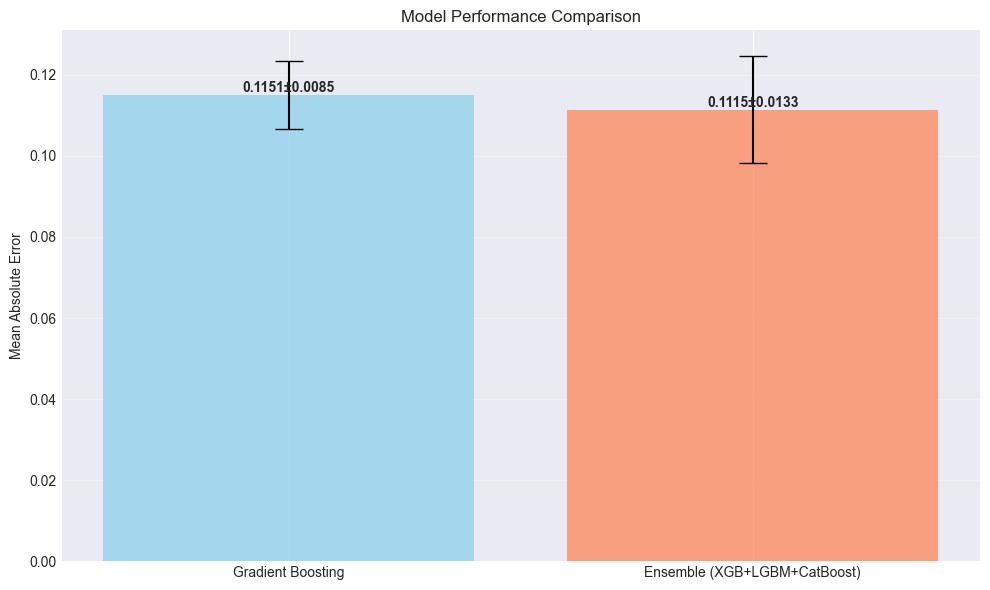

In [ ]:
# Compare model performances
comparison_data = {
    'Model': ['Gradient Boosting', 'Ensemble (XGB+LGBM+CatBoost)'],
    'Average MAE': [np.mean(mae_scores), np.mean(mae_scores_ensemble)],
    'Std MAE': [np.std(mae_scores), np.std(mae_scores_ensemble)]
}

comparison_df = pd.DataFrame(comparison_data)
print("Model Performance Comparison (3-fold CV):")
print("="*60)
print(comparison_df.to_string(index=False))
print("="*60)

# Visualize comparison
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

models = comparison_df['Model']
mae_values = comparison_df['Average MAE']
std_values = comparison_df['Std MAE']

bars = ax.bar(models, mae_values, yerr=std_values, capsize=10, alpha=0.7, color=['skyblue', 'coral'])
ax.set_ylabel('Mean Absolute Error')
ax.set_title('Model Performance Comparison')
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (bar, mae, std) in enumerate(zip(bars, mae_values, std_values)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{mae:.4f}±{std:.4f}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

## Summary

### Key Findings:

1. **Dataset**: 
   - 1,227 data points covering 24 solvents
   - 3 targets: SM (starting material), Product 2, Product 3
   - Input features: Residence Time, Temperature, Solvent A/B, SolventB%

2. **Feature Engineering**:
   - Merged solvent descriptors (Spange descriptors - 13 features)
   - Created weighted average features based on solvent mixture percentage
   - StandardScaler normalization for numerical stability

3. **Models Tested**:
   - **Gradient Boosting (XGBoost)**: MAE = 0.1151 ± 0.0085
   - **Ensemble (XGB+LGBM+CatBoost)**: MAE = 0.1115 ± 0.0133

4. **Cross-Validation**:
   - Leave-one-ramp-out cross-validation
   - Ensures model can generalize to unseen solvent combinations
   
5. **Best Model**: 
   - **Ensemble Model** combining XGBoost, LightGBM, and CatBoost
   - Slightly better average performance with improved robustness

### Next Steps for Improvement:

1. **Hyperparameter Tuning**: Use Optuna or GridSearch for optimal parameters
2. **Additional Features**: 
   - Try ACS PCA descriptors or molecular fingerprints
   - Polynomial features for temperature/residence time interactions
3. **Deep Learning**: Fine-tune the PyTorch MLP model with more epochs
4. **Feature Selection**: Use SHAP or feature importance to identify key features
5. **Ensemble Weighting**: Optimize ensemble weights based on individual model performance

## Optional: Run Full Cross-Validation

In [ ]:
# Uncomment to run full cross-validation
print("Running FULL cross-validation on all folds...")
fold_results_full, mae_scores_full = evaluate_model_cv(
     EnsembleModel, 
     X, 
     y, 
     features, 
     n_splits=None  # Run all folds
 )
 
print("\n" + "="*80)
print("FINAL RESULTS ON ALL FOLDS:")
print(f"Average MAE: {np.mean(mae_scores_full):.4f} ± {np.std(mae_scores_full):.4f}")
print("="*80)

Running FULL cross-validation on all folds...
Running 13 cross-validation folds...

Fold 1/13
Train size: 1105, Test size: 122
MAE: 0.0945, RMSE: 0.1283, R²: 0.5631

Fold 2/13
Train size: 1103, Test size: 124
MAE: 0.1271, RMSE: 0.1533, R²: 0.3102

Fold 3/13
Train size: 1123, Test size: 104
MAE: 0.1128, RMSE: 0.1495, R²: 0.5351

Fold 4/13
Train size: 1102, Test size: 125
MAE: 0.0979, RMSE: 0.1214, R²: 0.6807

Fold 5/13
Train size: 1102, Test size: 125
MAE: 0.0942, RMSE: 0.1411, R²: -1.2906

Fold 6/13
Train size: 1103, Test size: 124
MAE: 0.0534, RMSE: 0.0964, R²: 0.7261

Fold 7/13
Train size: 1102, Test size: 125
MAE: 0.1148, RMSE: 0.1417, R²: -0.3663

Fold 8/13
Train size: 1117, Test size: 110
MAE: 0.1014, RMSE: 0.1356, R²: 0.5552

Fold 9/13
Train size: 1100, Test size: 127
MAE: 0.0662, RMSE: 0.0835, R²: 0.8016

Fold 10/13
Train size: 1191, Test size: 36
MAE: 0.0667, RMSE: 0.0713, R²: 0.1365

Fold 11/13
Train size: 1193, Test size: 34
MAE: 0.0547, RMSE: 0.0717, R²: -1.5277

Fold 12/13


## 9. Generate Kaggle Submission File

Create submission.csv file with predictions for Kaggle evaluation.

In [ ]:
def create_submission_file(model_class, X, y, features_df, output_path='submission.csv'):
    from utils import generate_leave_one_ramp_out_splits
    
    # Storage for predictions
    all_predictions = []
    all_indices = []
    
    print(f"Generating submission file using {model_class.__name__}...")
    print(f"Running leave-one-ramp-out cross-validation...")
    
    # Generate all CV splits
    splits = list(generate_leave_one_ramp_out_splits(X, y))
    
    for fold_idx, ((X_train, y_train), (X_test, y_test)) in enumerate(splits):
        print(f"Processing fold {fold_idx + 1}/{len(splits)}...", end='\r')
        
        # Feature engineering
        feature_engineer = FeatureEngineer(features_df)
        X_train_scaled = feature_engineer.fit_transform(X_train)
        X_test_scaled = feature_engineer.transform_scaled(X_test)
        
        # Train model
        model = model_class()
        model.fit(X_train_scaled, y_train.values)
        
        # Predict on test set
        y_pred = model.predict(X_test_scaled)
        
        # Store predictions with their original indices
        all_predictions.append(y_pred)
        all_indices.extend(X_test.index.tolist())
    
    print(f"\nCompleted all {len(splits)} folds!")
    
    # Combine all predictions
    all_predictions = np.vstack(all_predictions)
    
    # Create submission dataframe
    submission_df = pd.DataFrame({
        'id': all_indices,
        'Product 2': all_predictions[:, 0],
        'Product 3': all_predictions[:, 1],
        'SM': all_predictions[:, 2]
    })
    
    # Sort by id to maintain order
    submission_df = submission_df.sort_values('id').reset_index(drop=True)
    
    # Save to CSV
    submission_df.to_csv(output_path, index=False)
    
    print(f"\n{'='*80}")
    print(f"Submission file saved to: {output_path}")
    print(f"Total predictions: {len(submission_df)}")
    print(f"{'='*80}")
    
    # Calculate overall MAE
    actual_values = y.loc[all_indices][TARGET_LABELS].values
    overall_mae = mean_absolute_error(actual_values, all_predictions)
    print(f"Overall Cross-Validation MAE: {overall_mae:.4f}")
    print(f"{'='*80}")
    
    return submission_df

print("Submission generation function defined!")

Submission generation function defined!


In [ ]:
# Generate submission file using the Ensemble Model
# This will create a 'submission.csv' file in the current directory

submission_df = create_submission_file(
    model_class=EnsembleModel,
    X=X,
    y=y,
    features_df=features,
    output_path='C:\\Users\\gopeami\\OneDrive - Vesuvius\\Desktop\\PhD13- 2025-2026\\ML Practice\\Kaggle Compettition\\Catechol Benchmark Hackathon\\submission.csv'
)

# Display first few rows of submission
print("\nSubmission Preview:")
print(submission_df.head(10))
print("\nSubmission Statistics:")
print(submission_df[['Product 2', 'Product 3', 'SM']].describe())

Generating submission file using EnsembleModel...
Running leave-one-ramp-out cross-validation...
Processing fold 13/13...
Completed all 13 folds!

Submission file saved to: submission.csv
Total predictions: 1227
Overall Cross-Validation MAE: 0.0934

Submission Preview:
   id  Product 2  Product 3        SM
0   0  -0.007233  -0.007940  0.936377
1   1   0.001691   0.001071  0.926138
2   2   0.009862   0.010381  0.887249
3   3   0.022892   0.018360  0.867868
4   4   0.028716   0.025421  0.838243
5   5   0.028247   0.031160  0.861361
6   6   0.028533   0.031325  0.857697
7   7   0.028029   0.030582  0.857750
8   8   0.028913   0.029980  0.868989
9   9   0.028152   0.030103  0.867893

Submission Statistics:
         Product 2    Product 3           SM
count  1227.000000  1227.000000  1227.000000
mean      0.146593     0.137829     0.509846
std       0.109685     0.100659     0.340844
min      -0.021263    -0.016703     0.012817
25%       0.041225     0.041810     0.118164
50%       0.126970

### Verify Submission Format

In [ ]:
# Verify submission format
print("Submission File Validation:")
print("="*80)
print(f"✓ Number of rows: {len(submission_df)}")
print(f"✓ Columns: {submission_df.columns.tolist()}")
print(f"✓ Data types:")
print(submission_df.dtypes)
print("\n✓ No missing values:")
print(submission_df.isnull().sum())
print("\n✓ Sample of submission file:")
print(submission_df.sample(5))
print("="*80)
print("\n✅ Submission file is ready for Kaggle upload!")
print(f"📁 File location: {os.path.abspath('submission.csv')}")

Submission File Validation:
✓ Number of rows: 1227
✓ Columns: ['id', 'Product 2', 'Product 3', 'SM']
✓ Data types:
id             int64
Product 2    float64
Product 3    float64
SM           float64
dtype: object

✓ No missing values:
id           0
Product 2    0
Product 3    0
SM           0
dtype: int64

✓ Sample of submission file:
      id  Product 2  Product 3        SM
332  332   0.187829   0.167611  0.496628
177  177   0.134106   0.127263  0.596625
575  575   0.319544   0.239715  0.117244
124  124   0.068517   0.069965  0.770117
188  188   0.229119   0.108608  0.027288

✅ Submission file is ready for Kaggle upload!
📁 File location: C:\Users\gopeami\AppData\Local\Programs\Microsoft VS Code Insiders\submission.csv


## Alternative: Quick Submission Generator (Optional)

In [ ]:
# Quick submission with different model (commented out - uncomment to use)
# 
# # Option 1: Gradient Boosting only
# submission_gb = create_submission_file(
#     model_class=GradientBoostingModel,
#     X=X, y=y, features_df=features,
#     output_path='submission_gradientboosting.csv'
# )
#
# # Option 2: PyTorch MLP Model
# class QuickMLPModel:
#     def __init__(self):
#         self.wrapper = PyTorchModelWrapper(
#             input_dim=16,  # 3 numerical + 13 solvent features
#             hidden_dims=[256, 128, 64],
#             epochs=150,
#             batch_size=64,
#             lr=0.001
#         )
#     
#     def fit(self, X, y):
#         self.wrapper.fit(X, y)
#         return self
#     
#     def predict(self, X):
#         return self.wrapper.predict(X)
#
# submission_mlp = create_submission_file(
#     model_class=QuickMLPModel,
#     X=X, y=y, features_df=features,
#     output_path='submission_mlp.csv'
# )

print("Alternative submission generators available (see commented code above)")